# Стилизация при помощи Adaptive Instance Normalization

Оригинальная статья: https://openaccess.thecvf.com/content_ICCV_2017/papers/Huang_Arbitrary_Style_Transfer_ICCV_2017_paper.pdf

#### Задача: имплементация архитектуры из статьи, обучение и сравнение с алгоритмом Гатиса.

# Содержание
## 1. [Краткий обзор идеи](#section1)
## 2. [Реализация архитектуры](#section2)
- ### [Энкодер](#section2.1)
- ### [AdaIN-блок](#section2.2)
- ### [Декодер](#section2.3)
- ### [Итоговый класс модели переноса стиля](#section2.4)
## 3. [Загрузка и предобработка датасета](#section3)
## 4. [Функции обучения модели](#section4)
## 5. [Запуск обучения](#section5)

## <a id="section1"> </a> 1. Краткий обзор идеи

![](./architecture.jpg)

<font size="4">
    Общая идея:
    <ol>
        <li> Используем первые слои VGG-19 в качестве энкодера. Получаем карты признаков для изображений контента и стиля.</li>
        <li> Для каждого канала полученных карт признаков в отдельности считаем среднее значение и стандартное отклонение. </li>
        <li> Нормализуем (меняем распределение) карт признаков контента согласно полученным статистикам для стиля. Получается перенос контента в распределение стиля. </li>
        <li> Преобразованные карты признаков нужно превратить снова в изображение, поэтому они подаются на вход в декодер, задача которого сгенерировать стилизованное трёхканальное изображение с исходными размерностями. </li>
        <li> Для обучения прогоняем полученную картинку снова через энкодер и считаем лосс по выходам энкодера. </li>
    </ol>
</font>

Лосс складывается из двух частей: потеря контента и потеря стиля. 

- `Потеря контента` - это просто MSELoss между выходом энкодера и выходом AdaIN.
- `Потеря стиля` - это разница между статистиками стиля после прохода через энкодер и статистиками сгенерированного изображения после энкодера.

### Импорты

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg19
import PIL
from PIL import Image

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## <center><a id="section2"></a>2. Реализация архитектуры </center>
### <a id="section2.1">2.1. Энкодер</a>

В оригинальной статье бралась вся модель вплоть до Relu_4_1. Это 20-й слой сети VGG19. Сделаем так же.

In [4]:
vgg = vgg19(True).features[:21]

for param in vgg.parameters():
    param.requires_grad = False
    
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

* блок-1: 0 - 4
* блок-2: 5 - 9
* блок-3: 10 - 18
* блок-4: 19 - 20

<font size="4">Потеря стиля в оригинальной статье считается после слоёв relu_1_1, relu_2_1, relu_3_1, relu_4_1, поэтому нужно иметь возможность получения выходов с каждого из этого слоя для рассчёта лосса.</font>

In [5]:
class Encoder(nn.Module):
    def __init__(self, base_cnn: nn.Sequential):
        super(Encoder, self).__init__()
        self.encoder = base_cnn

    def forward(self, inp, return_all_outputs=False):
        outp1 = self.encoder[:2](inp) # relu_1_1
        outp2 = self.encoder[2:7](outp1) # relu_2_1
        outp3 = self.encoder[7:12](outp2) # relu_3_1
        outp4 = self.encoder[12:21](outp3) # relu_4_1

        # для подсчёта потери стиля
        if return_all_outputs:
            return outp1, outp2, outp3, outp4
            
        return outp4    

### <a id="section2.2">2.2. AdaIN-блок</a>

- <font size="4"> блок Adaptive Instance Normalization, который получает `content_feature_maps` и `style_feature_maps`, рассчитывает для них векторы средних и стандартных отклонений (для каждого канала в отдельности), и приводит распределение `content_feature_maps` к распределению `style_feature_maps`. </font>

![](adain.jpg)

In [6]:
# Игрушечный пример расчёта mean и std для батча изображений
test = torch.tensor([
    [
        [
            [1, 2, 3, 4, 5],
            [5, 4, 3, 2, 1],
            [11, 12, 13, 14, 15]
        ],
        [
            [1, 2, 3, 4, 5],
            [5, 4, 3, 2, 1],
            [11, 12, 13, 14, 15]
        ],
        [
            [1, 1, 1, 0, 0],
            [0, 0, -35, 2, 1],
            [0, 500, 0, 11, 0]
        ]
    ]
], dtype=torch.float)

batch_size = test.size()[0]
channels = test.size()[1]
h = test.size()[2]
w = test.size()[3]

display(test.reshape(batch_size, channels, -1).mean(dim=2).reshape(batch_size, channels, 1, 1))
print()
display(test.reshape(batch_size, channels, -1).std(dim=2).reshape(batch_size, channels, 1, 1))

tensor([[[[ 6.3333]],

         [[ 6.3333]],

         [[32.1333]]]])

tensor([[[[  5.0943]],

         [[  5.0943]],

         [[129.7981]]]])

In [7]:
class MeanStdCalculator(nn.Module):
    """
    Модуль подсчёта среднего значения и стандартного отклонения по каждому каналу.
    Пригодится в блоке AdaIN, а также при вычислении потери стиля.
    """
    def __init__(self):
        super(MeanStdCalculator, self).__init__()

    def forward(self, feature_maps: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        batch_size = feature_maps.size()[0]
        channels = feature_maps.size()[1]
        
        mean = feature_maps.reshape(batch_size, channels, -1).mean(dim=2).reshape(batch_size, channels, 1, 1)
        std = feature_maps.reshape(batch_size, channels, -1).std(dim=2).reshape(batch_size, channels, 1, 1)

        return mean, std
        

class AdaIN(nn.Module):
    """
    Модуль адаптивной инстанс нормализации.
    Преобразует карты признаков контента согласно распределения карт признаков для стиля.
    """
    def __init__(self):
        super(AdaIN, self).__init__()
        self.mean_std_calc = MeanStdCalculator()
        
    def forward(self, content_features, style_features) -> torch.Tensor:
        content_mean, content_std = self.mean_std_calc(content_features)
        content_std = content_std + 1e-8
        style_mean, style_std = self.mean_std_calc(style_features)
        style_std = style_std + 1e-8

        norm_content = (content_features - content_mean) / content_std
        adapt_content = norm_content * style_std + style_mean

        return adapt_content

In [8]:
adapt_test = AdaIN()(test, test)
adapt_test

tensor([[[[  1.0000,   2.0000,   3.0000,   4.0000,   5.0000],
          [  5.0000,   4.0000,   3.0000,   2.0000,   1.0000],
          [ 11.0000,  12.0000,  13.0000,  14.0000,  15.0000]],

         [[  1.0000,   2.0000,   3.0000,   4.0000,   5.0000],
          [  5.0000,   4.0000,   3.0000,   2.0000,   1.0000],
          [ 11.0000,  12.0000,  13.0000,  14.0000,  15.0000]],

         [[  1.0000,   1.0000,   1.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000, -35.0000,   2.0000,   1.0000],
          [  0.0000, 500.0000,   0.0000,  11.0000,   0.0000]]]])

### <a id="section2.3">2.3. Декодер</a>

После блока AdaIN мы получаем выход t - нормализованные по параметрам стиля карты признаков. После этого данное представление t нужно восстановить до исходного размера изображений, получив стилизацию. 

В статье было предложено использовать в декодере nearest-upsampling для того, чтобы избегать появления артефактов на выходном изображении. 

In [9]:
# Сформируем правильную последовательность Upsampling для восстановления исходного размра изображения

# 1. Возьмем тестовую картинку и приведем ее к размеру 512х512
test_img = Image.open("../online-nst/data/contents/dancing.jpg").resize((512, 512))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)

# 2. Прогоним её через слои VGG-19, чтобы увидеть, как меняются ее размерности 
# с каждым max-pool размерность должна уменьшаться вдвое, а свертка с kernel_size=3, padding=1, stride=1 не должна менять размер. Проверим:
print(f"Исходная размерность: {test_img.size()}")

pool1 = vgg[:5](test_img)
print(f"pool1: {pool1.size()}")

pool2 = vgg[5:10](pool1)
print(f"pool2: {pool2.size()}")

pool3 = vgg[10:](pool2)
print(f"pool3: {pool3.size()}")

Исходная размерность: torch.Size([1, 3, 512, 512])
pool1: torch.Size([1, 64, 256, 256])
pool2: torch.Size([1, 128, 128, 128])
pool3: torch.Size([1, 512, 64, 64])


In [10]:
# 3. Добавим последовательность upsample блоков для восстановления размерности. Для регулирования количества каналов используем Conv2d
upsample = nn.Upsample(scale_factor=2, mode='nearest')
conv1 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

result = conv3(upsample(conv2(upsample(conv1(upsample(pool3))))))
print(f"Выходная размерность {result.size()}")

assert result.size() == test_img.size(), "Размерности должны были совпасть"

Выходная размерность torch.Size([1, 3, 512, 512])


Теперь можно реализовывать декодер...

In [11]:
class Decoder(nn.Module):
    """
    Декодер должен хорошо научиться восстанавливать изображения,
    для этого понадобится использовать бОльшее количество свёрток чем 3.
    """
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, inp):
        return self.block3(self.block2(self.block1(inp)))

In [12]:
encoded = vgg(test_img)
decoded = Decoder()(encoded)

decoded.size()

torch.Size([1, 3, 512, 512])

### <a id="section2.4">2.4. Итоговый класс модели переноса стиля</a>

In [13]:
class AdainStyleTransferModel(nn.Module):
    def __init__(self, base_cnn: nn.Sequential):
        super(AdainStyleTransferModel, self).__init__()
        self.encoder = Encoder(base_cnn=base_cnn)
        self.adain = AdaIN()
        self.decoder = Decoder()
        self.mean_std_calc = MeanStdCalculator()

    
    def stylize(self, content: torch.Tensor, style: torch.Tensor, alpha: float = 1.0):
        """
        Функция стилизации, которая будет применяться при инференсе.
        * alpha - число [0, 1], степень переноса стиля
        """
        content_features = self.encoder(content, return_all_outputs=False) # карты признаков контента с последнего слоя энкодера 
        style_features = self.encoder(style, return_all_outputs=False) # карты признаков стиля с последнего слоя энкодера
        
        adain_features = self.adain(content_features, style_features) # модифицированные карты признаков контента (стилизованные)
        adain_features = alpha * adain_features + (1 - alpha) * content_features # контроль степени стилизации при помощи alpha
        
        outp = self.decoder(adain_features) # получение стилизованного изображения исходного (512х512) размера
        
        return outp


    def __content_loss(self, result_enc_outp, adain_features):
        """
        * result_enc_outp - выход энкодера для D(adain_content), где D - декодер
        * adain_content - выход блока AdaIN, преобразованные фичи изначального контент-изображения
        """
        return torch.nn.MSELoss(reduction='mean')(result_enc_outp, adain_features)

    
    def __style_loss(self, result_enc_outputs, style_enc_outputs):
        """
        * result_enc_outputs - выходы всех рассмотренных выше слоев энкодера для полученной декодером стилизации
        * style_enc_outputs - выходы всех рассмотренных выше слоев энкодера для изображения стиля
        """
        style_loss_ = 0.0
        for result_outp, style_outp in zip(result_enc_outputs, style_enc_outputs):
            result_outp_mean, result_outp_std = self.mean_std_calc(result_outp)
            style_outp_mean, style_outp_std = self.mean_std_calc(style_outp)

            style_loss_ += torch.nn.MSELoss(reduction='mean')(result_outp_mean, style_outp_mean) + torch.nn.MSELoss(reduction='mean')(result_outp_std, style_outp_std)
            
        return style_loss_
        

    def forward(self, content_images, style_images, alpha=1.0, style_weight=10):
        content_features = self.encoder(content_images)
        style_features = self.encoder(style_images)
        
        adain_features = self.adain(content_features, style_features)
        adain_features = alpha * adain_features + (1 - alpha) * content_features
        
        result = self.decoder(adain_features)                 

        result_features = self.encoder(result, return_all_outputs=False)    
        result_all_features = self.encoder(result, return_all_outputs=True)   
        style_all_features = self.encoder(style_images, return_all_outputs=True)   

        
        content_loss = self.__content_loss(result_features, adain_features)     
        style_loss = self.__style_loss(result_all_features, style_all_features)  

        loss = content_loss + style_weight * style_loss
        
        return loss

In [14]:
from torchinfo import summary

model = AdainStyleTransferModel(vgg)

summary(model)

Layer (type:depth-idx)                   Param #
AdainStyleTransferModel                  --
├─Encoder: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (1,792)
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  (36,928)
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  (73,856)
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  (147,584)
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 (295,168)
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 (590,080)
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 (590,080)
│    │    └─ReLU: 3-16                   --
│    │    └─Conv2d: 3-17                 (590,080)
│    │    └─ReLU: 3

In [15]:
# проверим работоспособность forward-pass
loss = model(test_img, test_img)
loss

tensor(13.0628, grad_fn=<AddBackward0>)

In [16]:
# проверим работоспособность метода stylize и заодно замерим время инференса
import time

a = time.time()

model.stylize(test_img, test_img)

b = time.time()

print(b - a)

1.6364216804504395


## <center><a id="section3"></a>3. Загрузка и предобработка датасета </center>

<font size="4">
Для обучения модели были взяты следующие датасеты:
<ul>
    <li>MsCoco - изображения контента (https://www.kaggle.com/datasets/hariwh0/ms-coco-dataset) </li>
    <li>Wiki-art - изображения стилей (https://www.kaggle.com/datasets/steubk/wikiart)</li>
</ul>
</font>

In [17]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [18]:
import os
from PIL import Image

IMSIZE = (512, 512)
CROP_SIZE = (256, 256)

VGG19_NORMALIZATION_MEAN = torch.tensor([0.485, 0.456, 0.406])
VGG19_NORMALIZATION_STD = torch.tensor([0.229, 0.224, 0.225])

# Тренировочные данные
train_contents_directory = "../online-nst/data/contents/"
train_styles_directory = "../online-nst/data/styles/"

train_content_names = os.listdir(train_contents_directory) 
train_style_names = os.listdir(train_styles_directory)

train_content_paths = [train_contents_directory + i for i in train_content_names]
train_style_paths = [train_styles_directory + i for i in train_style_names]


# Тестовые данные
test_contents_directory = "../online-nst/data/contents/"
test_styles_directory = "../online-nst/data/styles/"

test_content_names = os.listdir(test_contents_directory) 
test_style_names = os.listdir(test_styles_directory)

test_content_paths = [test_contents_directory + i for i in test_content_names]
test_style_paths = [test_styles_directory + i for i in test_style_names]

In [19]:
class ImagesTrainDataset(Dataset):
    """
    Загрузка и предобработка изображений для тренировки.
    Нужно провести следующие преобразования над изображениями:
    * resize -> (512, 512)
    * random_crop -> (256, 256)
    * преобразование к тензору
    * нормализация согласно значениям для VGG-19
    """

    def __init__(self, files: list[str]):
        super(ImagesTrainDataset, self).__init__()
        
        self.files = sorted(files)
        self.len_ = len(self.files)


    def __len__(self):
        return self.len_


    def load_sample(self, file):
        with Image.open(file) as image:
            image.load()
            return image.resize(IMSIZE)


    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = transforms.RandomCrop(CROP_SIZE)(x)
        x = transforms.ToTensor()(x)[:3] # учитываем, что некоторые картинки могут иметь 4 канала, из-за чего нормализация может сломаться
        x = transforms.Normalize(VGG19_NORMALIZATION_MEAN, VGG19_NORMALIZATION_STD)(x)

        return x

In [20]:
class ImagesTestDataset(Dataset):
    """
    Загрузка и предобработка изображений для тестирования.
    Нужно провести следующие преобразования над изображениями:
    * resize -> (512, 512)
    * преобразование к тензору
    * нормализация согласно значениям для VGG-19
    """

    def __init__(self, files: list[str]):
        super(ImagesTestDataset, self).__init__()
        
        self.files = sorted(files)
        self.len_ = len(self.files)


    def __len__(self):
        return self.len_


    def load_sample(self, file):
        with Image.open(file) as image:
            image.load()
            return image.resize(IMSIZE)


    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = transforms.ToTensor()(x)[:3] # учитываем, что некоторые картинки могут иметь 4 канала, из-за чего нормализация может сломаться
        x = transforms.Normalize(VGG19_NORMALIZATION_MEAN, VGG19_NORMALIZATION_STD)(x)

        return x

In [21]:
def denorm_images(images):
    """
    Денормализация изображений на выходе.
    Args:
        * images (torch.Tensor) : батч нормализованных картинок
    """
    means = torch.tensor(VGG19_NORMALIZATION_MEAN).reshape(1, 3, 1, 1) 
    stds = torch.tensor(VGG19_NORMALIZATION_STD).reshape(1, 3, 1, 1) 

    return images * stds + means  

In [22]:
train_content_dataset = ImagesTrainDataset(train_content_paths)
train_style_dataset = ImagesTrainDataset(train_style_paths)

test_content_dataset = ImagesTestDataset(test_content_paths)
test_style_dataset = ImagesTestDataset(test_style_paths)

In [23]:
from torch.utils.data import DataLoader

train_content_dataloader = DataLoader(dataset=train_content_dataset, batch_size=1)
train_style_dataloader = DataLoader(dataset=train_style_dataset, batch_size=1)

test_content_dataloader = DataLoader(dataset=test_content_dataset, batch_size=1)
test_style_dataloader = DataLoader(dataset=test_style_dataset, batch_size=1)

____________________________

## <center><a id="section4"></a>4. Функции обучения модели. </center>

In [24]:
def train_epoch(model, optimizer, scheduler, device, 
                train_content_loader, train_style_loader, 
                checkpoints_path: str = "./checkpoints", save_freq: int = 1000, epoch_number: int = 1):
    model.train()
    
    style_iter = iter(train_style_loader)
    
    epoch_losses = []
    
    for i, content in tqdm(enumerate(train_content_loader)):
        try:
            content = content.to(device)
            style = next(style_iter)
            style = style.to(device)
            
            loss = model(content, style) # в батче у нас по одной картинке
            
            epoch_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                scheduler.step()

            if i % save_freq == 0:
                torch.save({
                    'epoch': epoch_number,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                }, f"{checkpoints_path}/epoch_{epoch_number}_iter_{i}.pt")
        
        except (OSError, PIL.Image.DecompressionBombError) as e:
            print(f"Skipping batch due to truncated image file.")
            continue
            
        except StopIteration as e:
            style_iter = iter(style_dl)
            continue
    epoch_losses = torch.tensor(epoch_losses, dtype=torch.float)
    
    return epoch_losses.mean().item()

In [25]:
def test_epoch(model, device, test_content_loader, test_style_loader, test_epoch_dir):
    model.eval()
    
    style_iter = iter(test_style_loader)
    
    for i, content in enumerate(test_content_loader):
        try:
            content = content.to(device)
            style = next(style_iter)
            style = style.to(device)
            
            output = model.stylize(content, style)
            output = denorm_images(output)
            output = transforms.ToPILImage()(output[0])
            output.save(f"{test_epoch_dir}/{i}.jpg")
            
        
        except (OSError, PIL.Image.DecompressionBombError) as e:
            print(f"Skipping batch due to truncated image file.")
            continue
            
        except StopIteration as e:
            style_iter = iter(style_dl)
            continue

In [26]:
from tqdm.auto import tqdm

def train(model, optimizer, scheduler, device, 
          train_content_loader: torch.utils.data.DataLoader, train_style_loader: torch.utils.data.DataLoader,
          test_content_loader: torch.utils.data.DataLoader, test_style_loader: torch.utils.data.DataLoader,
          num_steps: int, epoch_number: int = 1, checkpoints_path: str = "./checkpoints", save_freq: int = 1000, 
          test_outp_path: str = './test-outp'):
    """
    Параметры:
    * model - модель переноса стиля с замороженными слоями энкодера
    * optimizer - оптимизатор декодера модели 
    * scheduler - выполняет уменьшение learning_rate каждые 100 итерации, если не None
    * train_content_loader, train_style_loader - дата лоадеры
    * num_steps - количество эпох
    * epoch_number - номер текущей эпохи
    * checkpoint_path - путь до папки с чекпойтами модели
    * save_freq - частота сохранения модели, default=1000 - сохранять состояние модели каждые 1000 итераций
    """
    losses_list = []
    
    for step in tqdm(range(num_steps)):
        # train one epoch
        epoch_loss = train_epoch(model, optimizer, scheduler, device, 
                                 train_content_loader, train_style_loader, 
                                 checkpoints_path, save_freq, epoch_number + step)
        losses_list.append(epoch_loss)
        
        print(f"Epoch-{epoch_number + step}. Loss = {epoch_loss}")

        if test_outp_path:
            test_epoch_dir = os.path.join(test_outp_path, str(epoch_number + step))
            
            if not os.path.exists(test_epoch_dir):
                os.makedirs(test_epoch_dir)
                
            test_epoch(model, device, test_content_dataloader, test_style_dataloader, test_epoch_dir)
        
    return losses_list

______________________________________

## <center><a id="section5"></a>5. Обучение модели.</center>

In [46]:
import torch.optim as optim

In [47]:
base_cnn = vgg19(True).features[:21]

for param in base_cnn.parameters():
    param.requires_grad = False

LR = 0.001
GAMMA = 0.9995
    
model = AdainStyleTransferModel(base_cnn).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=GAMMA)

summary(model)

Layer (type:depth-idx)                   Param #
AdainStyleTransferModel                  --
├─Encoder: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (1,792)
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  (36,928)
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  (73,856)
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  (147,584)
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 (295,168)
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 (590,080)
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 (590,080)
│    │    └─ReLU: 3-16                   --
│    │    └─Conv2d: 3-17                 (590,080)
│    │    └─ReLU: 3

In [29]:
!mkdir ./checkpoints
!mkdir ./test-outp

mkdir: невозможно создать каталог «./checkpoints»: Файл существует
mkdir: невозможно создать каталог «./test-outp»: Файл существует


In [30]:
losses = train(
    model, optimizer, scheduler, device,
    train_content_loader=train_content_dataloader,
    train_style_loader=train_style_dataloader,
    test_content_loader=test_content_dataloader,
    test_style_loader=test_style_dataloader,
    num_steps=1,
    epoch_number=1,
    checkpoints_path='./checkpoints',
    save_freq=10
)

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch-1. Loss = 305.49224853515625


In [48]:
def load_model(path: str, device, lr, gamma):
    base_cnn = vgg19(True).features[:21]

    for param in base_cnn.parameters():
        param.requires_grad = False

    model = AdainStyleTransferModel(base_cnn).to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

    return model, optimizer, scheduler, epoch, loss

In [49]:
model, optimizer, scheduler, epoch, loss = load_model('./checkpoints/epoch_5.pt', device, LR, GAMMA)

In [59]:
c_it = iter(test_content_dataloader)
s_it = iter(test_style_dataloader)

In [51]:
content

tensor([[[[ 0.8789,  0.8789,  0.8789,  ...,  1.1700,  1.1700,  1.1700],
          [ 0.8618,  0.8618,  0.8618,  ...,  1.1529,  1.1700,  1.1700],
          [ 0.8276,  0.8276,  0.8276,  ...,  1.1358,  1.1529,  1.1529],
          ...,
          [-0.3541, -0.3883, -0.4568,  ..., -0.9020, -0.9192, -0.9192],
          [-0.5938, -0.6281, -0.6623,  ..., -0.9020, -0.9192, -0.9363],
          [-0.7650, -0.7650, -0.7822,  ..., -0.9020, -0.9192, -0.9363]],

         [[ 0.2052,  0.2052,  0.2052,  ..., -0.0574, -0.0574, -0.0574],
          [ 0.1877,  0.1877,  0.1877,  ..., -0.0574, -0.0574, -0.0574],
          [ 0.1527,  0.1527,  0.1527,  ..., -0.0574, -0.0399, -0.0399],
          ...,
          [-1.1954, -1.2129, -1.2479,  ..., -0.4601, -0.4776, -0.4776],
          [-1.4230, -1.4405, -1.4405,  ..., -0.4601, -0.4776, -0.4951],
          [-1.5630, -1.5630, -1.5630,  ..., -0.4601, -0.4776, -0.4951]],

         [[-1.1421, -1.1421, -1.1421,  ..., -0.5844, -0.5844, -0.5844],
          [-1.1596, -1.1596, -

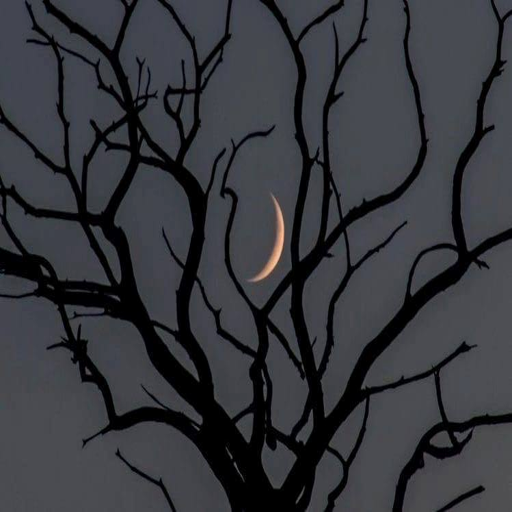

In [52]:
transforms.ToPILImage()(denorm_images(style)[0])

In [88]:
content = next(c_it)
style = next(s_it)

In [89]:
outp = model.stylize(content, style)

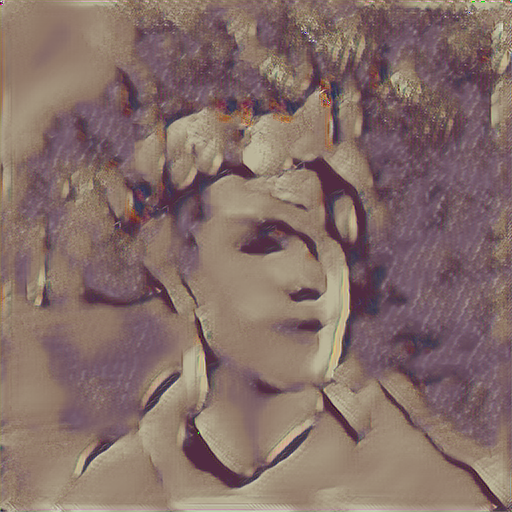

In [90]:
transforms.ToPILImage()(denorm_images(outp)[0])

In [68]:
outp = outp.clip_(0, 1)